# Rate Equation
## Objective
1. Define equation
2. Solve equation
3. Compute model and signal


In this example, we only deal with gaussian irf 

In [23]:
# import needed module
import numpy as np
import matplotlib.pyplot as plt
import TRXASprefitpack
from TRXASprefitpack import solve_model, solve_seq_model, solve_l_model, compute_model, rate_eq_conv 
plt.rcParams["figure.figsize"] = (12,9)

## Version information

In [2]:
print(TRXASprefitpack.__version__)

0.6.0


## Define equation -sequential decay-

In pump-probe time resolved spectroscopy, 
the concentration of ground state is not much important.
Only, the concentration of excited species are matter.

Consider following sequential decay model
```{code-block} python
'''
    k1     k2
A  ---> B ---> GS
y1: A
y2: B
y3: GS
'''
```

with initial condition 
\begin{equation*}
y(t) = \begin{cases}
(0, 0, 1) & \text{if $t < 0$}, \\
(1, 0, 0) & \text{if $t=0$}.
\end{cases}
\end{equation*}

Then what we need to solve is

\begin{equation*}
y'(t) = \begin{cases}
(0, 0, 0) & \text{if $t < 0$}, \\
Ay(t) & \text{if $t \geq 0$}
\end{cases}
\end{equation*}

with $y(0)=y_0$.

Where $A$ is

\begin{equation*}
A = \begin{pmatrix}
-k_1 & 0 & 0 \\
k_1 & -k_2 & 0 \\
0 & k_2 & 0
\end{pmatrix}
\end{equation*}

This type of 1st order rate equation can be solved via ``solve_seq_model``. Indeed ``solve_seq_model`` can solve following type of sequential decay.

```{code-block}python

1 --> 2 --> 3 --> ... --> n
```

In [8]:
# set lifetime tau1 = 500 ps, tau2 = 10 ns
# set fwhm of IRF = 100 ps

tau_1 = 500
tau_2 = 10000
fwhm = 100

# initial condition
y0 = np.array([1, 0, 0])

# set time range (mixed step)
t_seq1 = np.arange(-2500, -500, 100)
t_seq2 = np.arange(-500, 1500, 50)
t_seq3 = np.arange(1500, 5000, 250)
t_seq4 = np.arange(5000, 50000, 2500)

t_seq = np.hstack((t_seq1, t_seq2, t_seq3, t_seq4))

eigval_seq, V_seq, c_seq = solve_seq_model(np.array([tau_1, tau_2]), y0)

In [9]:
# Now compute model
y_seq = compute_model(t_seq, eigval_seq, V_seq, c_seq)


# since, y_1 + y_2 + y_3 = 1 for all t,
# y3 = 1 - (y_1+y_2)

y_seq[-1, :] = 1 - (y_seq[0, :] + y_seq[1, :])

## plot model (sequential decay model)

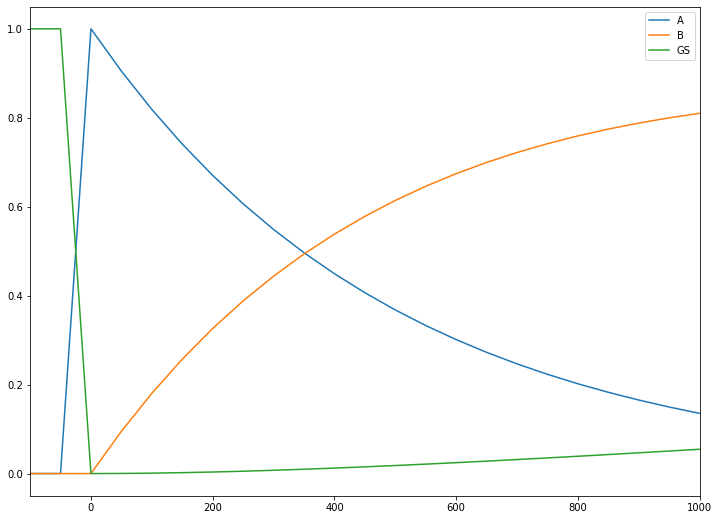

In [24]:
plt.plot(t_seq, y_seq[0, :], label='A')
plt.plot(t_seq, y_seq[1, :], label='B')
plt.plot(t_seq, y_seq[2, :], label='GS')
plt.xlim(-100, 1000)
plt.legend()
plt.show()

Convolution with gaussian instrumental response function

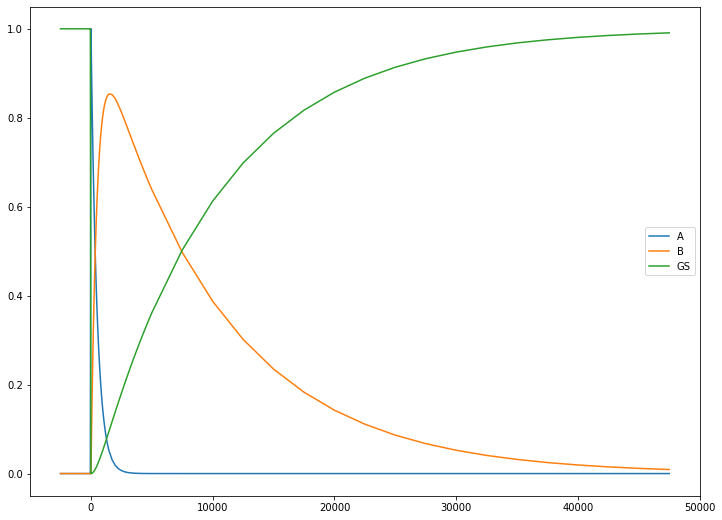

In [25]:
plt.plot(t_seq, y_seq[0, :], label='A')
plt.plot(t_seq, y_seq[1, :], label='B')
plt.plot(t_seq, y_seq[2, :], label='GS')
plt.legend()
plt.show()

## Compute Signal for sequential decay
Difference absorption coefficient of ground state is 0

case 1. Differential absorption coefficient of A : -0.5 and B : 1

case 2. A: 0.5 B: 1

case 3. A: 1 B: 0.5

case 4. A: 1 B: 1

In [13]:
diff_abs_1 = [-0.5, # A state
            1, # B state
            0, # ground state
           ]
diff_abs_2 = [0.5, 1, 0]
diff_abs_3 = [1, 0.5, 0]
diff_abs_4 = [1, 1, 0]
y_seq_1 = rate_eq_conv(t_seq, fwhm, diff_abs_1, eigval_seq, V_seq, c_seq)
y_seq_2 = rate_eq_conv(t_seq, fwhm, diff_abs_2, eigval_seq, V_seq, c_seq)
y_seq_3 = rate_eq_conv(t_seq, fwhm, diff_abs_3, eigval_seq, V_seq, c_seq)
y_seq_4 = rate_eq_conv(t_seq, fwhm, diff_abs_4, eigval_seq, V_seq, c_seq)


## Plot signal (sequential decay)

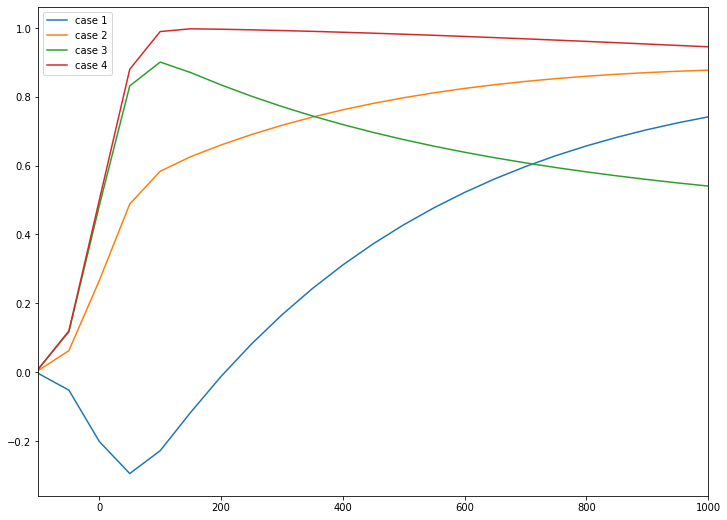

In [26]:
plt.plot(t_seq, y_seq_1, label='case 1')
plt.plot(t_seq, y_seq_2, label='case 2')
plt.plot(t_seq, y_seq_3, label='case 3')
plt.plot(t_seq, y_seq_4, label='case 4')
plt.xlim(-100, 1000)
plt.legend()
plt.show()

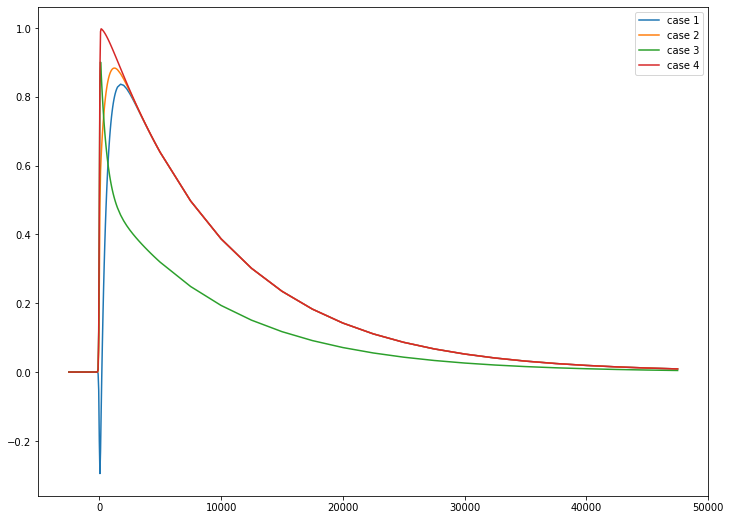

In [27]:
plt.plot(t_seq, y_seq_1, label='case 1')
plt.plot(t_seq, y_seq_2, label='case 2')
plt.plot(t_seq, y_seq_3, label='case 3')
plt.plot(t_seq, y_seq_4, label='case 4')
plt.legend()
plt.show()

## Define equation -branched decay-


Consider following branched decay model
```{code-block} python
'''
    k1     k3    
A  ---> B ---> GS
 \      
  \   
k2 \     
    \    
     > C ---> GS
          k4   
y1: A
y2: B
y3: C
y4: GS
'''
```

with initial condition 
\begin{equation*}
y(t) = \begin{cases}
(0, 0, 0, 1) & \text{if $t < 0$}, \\
(1, 0, 0, 0) & \text{if $t=0$}.
\end{cases}
\end{equation*}

Then what we need to solve is

\begin{equation*}
y'(t) = \begin{cases}
(0, 0, 0, 0) & \text{if $t < 0$}, \\
Ay(t) & \text{if $t \geq 0$}
\end{cases}
\end{equation*}

with $y(0)=y_0$.

Where $A$ is

\begin{equation*}
A = \begin{pmatrix}
-(k_1+k2) & 0 & 0 & 0 \\
k_1 & -k_3 & 0 & 0 \\
k_2 & 0 & -k_4 & 0 \\
0 & k_3 & k_4 & 0
\end{pmatrix}
\end{equation*}

As one can see the rate equation matrix ``A`` is lower triangle.

This lower triangle type 1st order rate equation can be solved via ``solve_l_model``

In [16]:
# set lifetime tau1: 300 fs, tau2: 500 fs, tau3: 1 ns, tau 4: 500 ps 
# set fwhm of IRF = 150 fs

tau_1 = 0.3
tau_2 = 0.5
tau_3 = 1000
tau_4 = 500
fwhm = 0.15

# initial condition
y0 = np.array([1, 0, 0, 0])

# rate equation matrix 
A = np.array([[-(1/tau_1+1/tau_2), 0, 0, 0],
[1/tau_1, -1/tau_3, 0, 0],
[1/tau_2, 0, -1/tau_4, 0],
[0,1/tau_3, 1/tau_4, 0]
])


# set time range (mixed step)
t_1 = np.arange(-2, -1, 0.1)
t_2 = np.arange(-1, 1, 0.05)
t_3 = np.arange(1, 10, 1)
t_4 = np.arange(10, 100, 10)
t_5 = np.arange(100, 1500, 100)

t_branch = np.hstack((t_1, t_2, t_3, t_4, t_5))

eigval_branch, V_branch, c_branch = solve_l_model(A, y0)



In [17]:
# Now compute model
y_branch = compute_model(t_branch, eigval_branch, V_branch, c_branch)


# since, y_1 + y_2 + y_3 + y_4 = 1 for all t,
# y4 = 1 - (y_1+y_2+y_3)

y_branch[-1, :] = 1 - (y_branch[0, :] + y_branch[1, :] + y_branch[2, :])

## plot model (branched decay model)

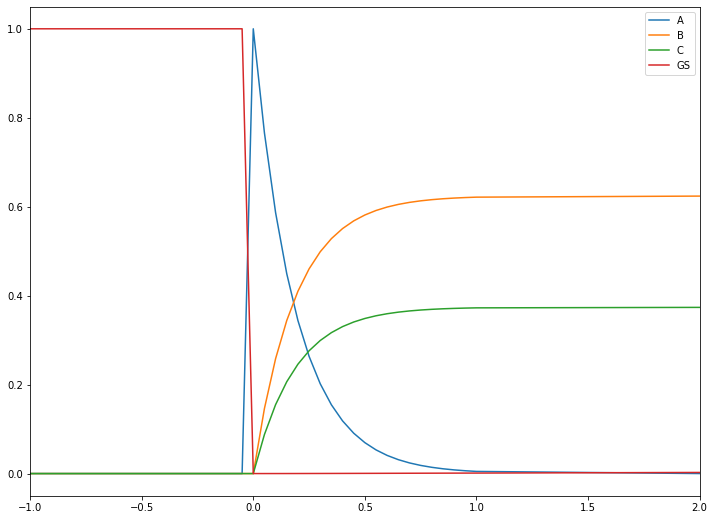

In [28]:
plt.plot(t_branch, y_branch[0, :], label='A')
plt.plot(t_branch, y_branch[1, :], label='B')
plt.plot(t_branch, y_branch[2, :], label='C')
plt.plot(t_branch, y_branch[3, :], label='GS')
plt.legend()
plt.xlim(-1, 2)
plt.show()

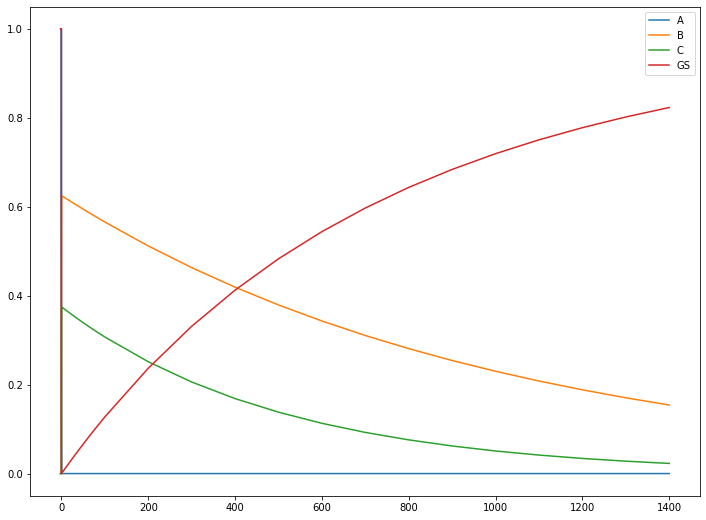

In [29]:
plt.plot(t_branch, y_branch[0, :], label='A')
plt.plot(t_branch, y_branch[1, :], label='B')
plt.plot(t_branch, y_branch[2, :], label='C')
plt.plot(t_branch, y_branch[3, :], label='GS')
plt.legend()
plt.show()

## Compute Signal for branched decay
Difference absorption coefficient of ground state is 0

case 1. Differential absorption coefficient of A : -0.5 and B : 1  C: 1

case 2. A: 0.5 B: 1 C: 0.8

case 3. A: 0.5 B: 0.5 C: 1

case 4. A: -0.5 B: -0.5 C: 1

In [20]:
diff_abs_1 = [-0.5, # A state
            1, # B state
            1, # C
            0, # Ground State
           ]
diff_abs_2 = [0.5, 1, 0.8, 0]
diff_abs_3 = [0.5, 0.5, -1, 0]
diff_abs_4 = [-0.5, -0.5, 1, 0]
y_branch_1 = rate_eq_conv(t_branch, fwhm, diff_abs_1, eigval_branch, V_branch, c_branch)
y_branch_2 = rate_eq_conv(t_branch, fwhm, diff_abs_2, eigval_branch, V_branch, c_branch)
y_branch_3 = rate_eq_conv(t_branch, fwhm, diff_abs_3, eigval_branch, V_branch, c_branch)
y_branch_4 = rate_eq_conv(t_branch, fwhm, diff_abs_4, eigval_branch, V_branch, c_branch)

## Plot Signal for branched decay

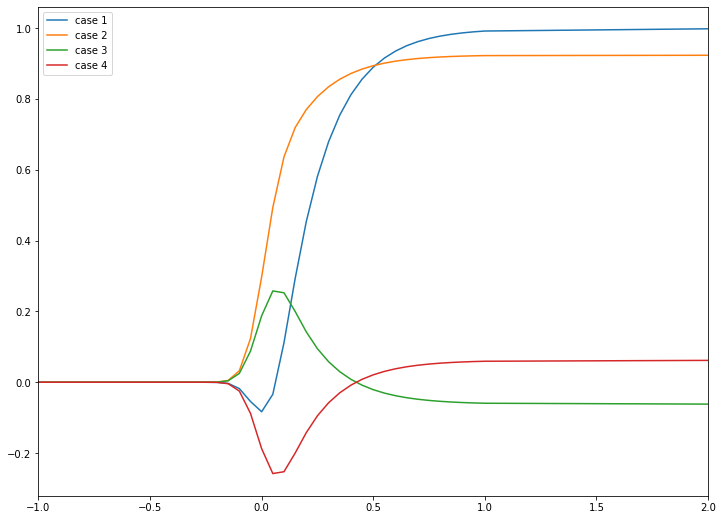

In [30]:
plt.plot(t_branch, y_branch_1, label='case 1')
plt.plot(t_branch, y_branch_2, label='case 2')
plt.plot(t_branch, y_branch_3, label='case 3')
plt.plot(t_branch, y_branch_4, label='case 4')
plt.legend()
plt.xlim(-1, 2)
plt.show()

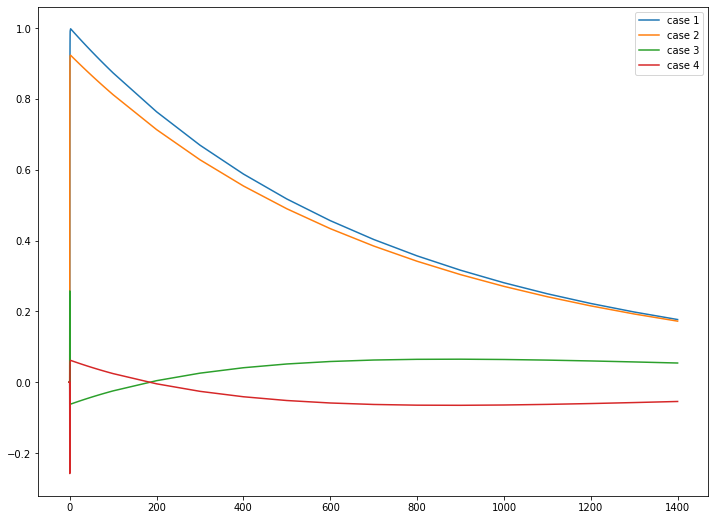

In [31]:
plt.plot(t_branch, y_branch_1, label='case 1')
plt.plot(t_branch, y_branch_2, label='case 2')
plt.plot(t_branch, y_branch_3, label='case 3')
plt.plot(t_branch, y_branch_4, label='case 4')
plt.legend()
plt.show()

## Conclusion
This example introduce ``solve_seq_model`` and ``solve_l_model`` to solve special kind of rate equation and demonstrates how signal changes when varying differential absolution coefficients of each excited state species. 